# Identify Interaction Domains

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from random import shuffle
from pathlib import Path

import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# input homer significant interaction table, return intra interactions by chr

def merge_interaction(df, binsize, verbose=False, eps=0.001, min_samples=5):
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[-1]) // binsize)
    
    coord_df = pd.DataFrame([x, y]).T
    coord_df['chr(1)'] = df['chr(1)'].tolist()[0]
    coord_df['chr(2)'] = df['chr(2)'].tolist()[0]
    
    X = np.array(list(zip(x, y)))
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    
    if verbose:
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters in %s vs %s: %d' % 
              (df['chr(1)'][0], df['chr(2)'][0], n_clusters_))
    
    coord_df['cluster_dbscan'] = list(map(int, labels))
    return coord_df


def merge_cluster(df):
    square_size = (df['PeakID(1)'].max() - df['PeakID(1)'].min() + 1) * \
                  (df['PeakID(2)'].max() - df['PeakID(2)'].min() + 1)
    real_interaction = df.shape[0]
    precent = real_interaction/square_size
    line = [[df['PeakID(1)'].min(), df['PeakID(1)'].max(), 
                          df['PeakID(2)'].min(), df['PeakID(2)'].max(),
                          real_interaction, square_size, precent]]
    if df['cluster_dbscan'][0] == -1:
        line = [[0, 0, 0, 0, 0, 0, 0]]
    return pd.DataFrame(line, columns=['peak1_start', 'peak1_end', 'peak2_start', 'peak2_end',
                                       'interactions', 'region_size', 'percentage'])


def merge_homer_inter_table(fp, binsize=20000, eps=0.001, min_samples=5, merge=False):
    df_list = []
    df = pd.read_table(fp, index_col=0)
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster

    
def merge_inter_df(df, binsize=20000, eps=0.001, min_samples=5, merge=False):
    cluster = df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=binsize,
                                                     eps=eps, min_samples=min_samples)
    if merge:
        merge = cluster.groupby(['chr(1)', 'chr(2)', 'cluster_dbscan']).apply(merge_cluster)
        merge.reset_index(inplace=True)
        merge.drop('level_3', inplace=True, axis=1)
        return merge
    else:
        return cluster
    
    
def plot_cluster(df, chrom='chr1', region=[1000, 2000], figsize=10, outliers=False, cluster_color = True, unicolor=(0,0.5,0.5)):
    chr_df = df[df['chr(1)'] == chrom]
    
    if outliers:
        out_color = (0.7,0.7,0.7)
    else:
        out_color = (1,1,1)
    if cluster_color:
        colors = sns.color_palette("husl", int(chr_df['cluster_dbscan'].max()) + 1)
        shuffle(colors)
        color_list = chr_df['cluster_dbscan'].apply(lambda i: colors[int(i)] if i != -1 else out_color)
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)'], color_list], index=['x', 'y', 'color']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)'], color_list], index=['x', 'y', 'color']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    else:
        chr_df = chr_df[chr_df['cluster_dbscan'] >= 0]
        scatter_df = pd.DataFrame([chr_df['PeakID(1)'], chr_df['PeakID(2)']], index=['x', 'y']).T
        r_scatter_df = pd.DataFrame([chr_df['PeakID(2)'], chr_df['PeakID(1)']], index=['x', 'y']).T
        scatter_df = pd.concat([scatter_df, r_scatter_df])
        sub_scatter_df = scatter_df[(scatter_df['x'] > region[0]) & (scatter_df['x'] < region[1]) & 
                            (scatter_df['y'] > region[0]) & (scatter_df['y'] < region[1])]
    fig, ax=plt.subplots()
    fig.set_size_inches(figsize, figsize)
    if cluster_color:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=sub_scatter_df['color'], s=5, marker="s")
    else:
        ax.scatter(sub_scatter_df['x'], sub_scatter_df['y'], c=unicolor, s=5, marker="s")
    ax.set_xlim(region)
    ax.set_ylim(region)
    
    plt.show()
    return


def average_interaction(df, binsize, merge_field, ave_size=3):
    ave_size = ( ave_size // 2 ) * 2 + 1
    expend = ave_size // 2
    x = df['PeakID(1)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    y = df['PeakID(2)'].apply(lambda i: int(i.split('-')[1]) // binsize)
    chrom1 = df['chr(1)'][0]
    chrom2 = df['chr(2)'][0]
    
    raw_array = np.zeros((max(x) + 2 * expend, max(y) + 2 * expend))
    for i, row in df.iterrows():
        x_row = int(row['PeakID(1)'].split('-')[1]) // binsize
        y_row = int(row['PeakID(2)'].split('-')[1]) // binsize
        raw_array[x_row + expend, y_row + expend] = row[merge_field]
    total_rows = []
    
    point_set = set()
    for pair in zip(x.tolist(), y.tolist()):
        for i in range(-expend, expend+1):
            for j in range(-expend, expend+1):
                point_set.add((pair[0]+i, pair[1]+j))
    
    for x, y in list(point_set):
        ave_region = raw_array[x : x + 2 * expend + 1, y : y + 2 * expend + 1].flatten()
        ave_value = ave_region[np.nonzero(ave_region)].mean()
        if not np.isnan(ave_value):
            total_rows.append([chrom1, chrom2, chrom1 + '-' + str(x*binsize), chrom2 + '-' + str(y*binsize), ave_value])
    return pd.DataFrame(total_rows, columns=['chr(1)', 'chr(2)', 'PeakID(1)', 'PeakID(2)', merge_field])


def diff_interaction(cd1_df, cd2_df, ave_size=3, binsize=20000, delta_z_cutoff=0.1, eps=0.001, min_samples=17):
    cd1_df_ave = cd1_df.groupby(['chr(1)', 'chr(2)']).apply(average_interaction, binsize, merge_field='Z-score', ave_size=ave_size)
    cd1_df_ave.reset_index(drop=True, inplace=True)
    cd1_df_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)
    
    cd2_df_ave = cd2_df.groupby(['chr(1)', 'chr(2)']).apply(average_interaction, binsize, merge_field='Z-score', ave_size=ave_size)
    cd2_df_ave.reset_index(drop=True, inplace=True)
    cd2_df_ave.set_index(['PeakID(1)', 'PeakID(2)'], inplace=True)
    
    df = pd.concat([cd1_df_ave, cd2_df_ave[['Z-score']]], axis=1)
    df.columns = ['chr(1)', 'chr(2)', 'Z-score-1', 'Z-score-2']
    df['Z-score-1'].fillna(0, inplace=True)
    df['Z-score-2'].fillna(0, inplace=True)
    df.reset_index(inplace=True)
    df.drop(['chr(1)', 'chr(2)'], inplace=True, axis=1)
    df['chr(1)'] = df['PeakID(1)'].apply(lambda i: i.split('-')[0])
    df['chr(2)'] = df['PeakID(2)'].apply(lambda i: i.split('-')[0])
    
    df['delta_zscore'] = df['Z-score-1'] - df['Z-score-2']
    df['cd1_only'] = df['Z-score-2'] == 0
    df['cd2_only'] = df['Z-score-1'] == 0
    
    cd1_only = df[df['cd1_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-1']]
    cd1_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']
    
    cd2_only = df[df['cd2_only']][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-2']]
    cd2_only.columns = ['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score']
    
    cd1_positive = df[df['delta_zscore'] > delta_z_cutoff][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-1']]
    cd2_positive = df[df['delta_zscore'] < -delta_z_cutoff][['PeakID(1)', 'PeakID(2)', 'chr(1)', 'chr(2)', 'Z-score-2']]
    cd2_positive.head()
    
    ax = sns.distplot(df['delta_zscore'], bins=500, kde=False, color='steelblue')
    sns.distplot(df['Z-score-1'][df['Z-score-1'] > 0], bins=500, kde=False, color='salmon', ax=ax)
    sns.distplot(-df['Z-score-2'][df['Z-score-2'] > 0], bins=500, kde=False, color='lightseagreen', ax=ax)
    ax.set_xlim((-3, 3))
    
    cd1_positive_cluster = cd1_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                eps=eps, min_samples=min_samples)
    cd2_positive_cluster = cd2_positive.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                eps=eps, min_samples=min_samples)
    return cd1_positive_cluster, cd2_positive_cluster

In [4]:
dirp = Path('/Users/hq/Documents/data/hic/')
cd1_df = pd.read_table(dirp / 'dn3' / 'DN3_Interactions_20K.txt', index_col=0)
cd2_df = pd.read_table(dirp / 'dp' / 'DP_Interactions_20K.txt', index_col=0)



Used 58 seconds.


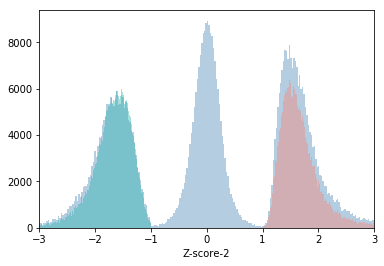

In [5]:
start = time.time()
cd1_raw_cluster = cd1_df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)
cd2_raw_cluster = cd2_df.groupby(['chr(1)', 'chr(2)']).apply(merge_interaction, binsize=20000,
                                                     eps=0.001, min_samples=4)

cd1_positive_cluster, cd2_positive_cluster = diff_interaction(cd1_df, cd2_df, ave_size=3, binsize=20000, 
                                                              delta_z_cutoff=0.1, eps=0.001, min_samples=17)
end = time.time()
print('Used %d seconds.' % int(end-start))

cd1_raw_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd1_raw_cluster.drop('chr(2)', inplace=True, axis=1)
cd2_raw_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd2_raw_cluster.drop('chr(2)', inplace=True, axis=1)
cd1_positive_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd1_positive_cluster.drop('chr(2)', inplace=True, axis=1)
cd2_positive_cluster.set_index(['PeakID(1)', 'PeakID(2)', 'chr(1)'], inplace=True)
cd2_positive_cluster.drop('chr(2)', inplace=True, axis=1)

In [39]:
cd2_positive_cluster.head()

cluster_dbscan
PeakID(1) PeakID(2) chr(1)                
500       487       chr1                 0
          488       chr1                 0
          489       chr1                 0
          490       chr1                 0
5000      5000      chr1                -1

In [40]:
cd2_raw_cluster.head(

,,,cluster_dbscan
PeakID(1),PeakID(2),chr(1),
8394,8384,chr2,0
7173,7157,chr7,0
1371,1364,chr2,1
1761,1758,chr17,0
4036,4024,chr18,0


In [ ]:
def read_chrom_matrix(dir_path, condition, chrom, binsize):
    dirp = Path(dir_path)
    fp = dirp / '%s.%s.%s.tsv' % (condition, chrom, binsize)
    start = time.time()
    chrom_matrix = pd.read_table(fp, index_col=[0, 1])
    col_list = list(map(lambda i: int(i.split('-')[1]) // binsize, chrom_matrix.columns.tolist()))
    chrom_matrix.reset_index(drop=True, inplace=True)
    chrom_matrix.columns = col_list
    end = time.time()
    print('Used %d seconds to read in %s matrix.' % (int(end-start), chrom))
    return chrom_matrix

chrom_matrix = read_chrom_matrix(dir_path='/Users/hq/Documents/data/hic',
                                 condition='dn3', chrom='chr10', binsize=20000)

In [52]:
summary_df = pd.concat([cd1_raw_cluster, cd2_raw_cluster, cd1_positive_cluster, cd2_positive_cluster], axis=1)
summary_df.reset_index(inplace=True)
summary_df.columns = ['x', 'y', 'chrom', 'cd1_raw_cluster', 'cd2_raw_cluster', 'cd1_positive_cluster', 'cd2_positive_cluster']

summary_df = summary_df[summary_df['x'] >= summary_df['y']]

In [63]:
chrom = 'chr10'
x_select = slice(1000, 2000)
y_select = slice(1000, 2000)
heatmap_matrix = chrom_matrix.iloc[x_select, y_select]
interaction_select = summary_df[(summary_df['chrom'] == chrom) & 
                                (summary_df['x'] > x_select.start) & (summary_df['x'] < x_select.stop) & 
                                (summary_df['y'] > y_select.start) & (summary_df['y'] < y_select.stop)]

-1.0      359
 11.0      78
 3.0       57
 0.0       51
 36.0      42
 49.0      29
 39.0      27
 64.0      27
 42.0      23
 150.0     22
 37.0      20
 126.0     16
 131.0     15
 85.0      13
 66.0      12
 78.0      10
 146.0     10
 72.0       9
 105.0      9
 127.0      8
 162.0      7
 222.0      7
 180.0      6
 69.0       6
 24.0       6
 161.0      6
 181.0      6
 175.0      5
 104.0      5
 114.0      5
 218.0      5
 148.0      4
 189.0      4
 202.0      4
 210.0      4
 183.0      4
Name: cd1_raw_cluster, dtype: int64